## Install libs and SageMaker

In [ ]:
!pip install -U pip
!pip install sagemaker==2.15.3
!pip install boto3==1.16.2
!pip install pandas==1.0.1
!pip install numpy==1.18.1
!pip install matplotlib==3.3.3
!pip install scikit-learn==0.24.0

## Import libs and create constant 

In [2]:
import os
import io
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from time import strftime, gmtime

In [3]:
import sys
import os

sys.path.append("./")

In [4]:
# Import lib boto3
import boto3

In [5]:
# Create session Boto3
session_boto = boto3.Session(region_name='us-east-1')

In [6]:
# Import to get de role 
from sagemaker import get_execution_role

In [7]:
# Save de role 
ROLE = get_execution_role()

In [ ]:
print(ROLE)

In [9]:
# Import SageMaker SDK
import sagemaker

In [10]:
# Create a session in SageMaker SDK with the boto session.
session_sagemaker_sdk = sagemaker.Session(boto_session=session_boto)

In [11]:
session_sagemaker_boto = boto3.Session().client('sagemaker')

In [12]:
# Bucket name.
BUCKET ='mybucketmlyci'

# tag data 
TAG_DATA = 'data'

# tag model
TAG_MODEL = 'model'

# Region 
REGION = boto3.Session().region_name

SEED = 42

In [13]:
# dict dir data
dict_dir_data = {
    "train": "../data/df_bytebank_treino.csv",
    "test": "../data/df_bytebank_teste.csv",
    "validation": "../data/df_bytebank_validacao.csv",    
}

## Dir S3 and Training Inputs

In [14]:
bytebank_train_dir = session_sagemaker_sdk.upload_data(path=dict_dir_data['train'],
                                                       bucket=BUCKET,
                                                       key_prefix=f'{TAG_DATA}/train')

In [15]:
bytebank_train_dir

's3://mybucketmlyci/data/train/df_bytebank_treino.csv'

In [16]:
bytebank_test_dir = session_sagemaker_sdk.upload_data(path=dict_dir_data['test'],
                                                      bucket=BUCKET,
                                                      key_prefix=f'{TAG_DATA}/test')

In [17]:
bytebank_test_dir

's3://mybucketmlyci/data/test/df_bytebank_teste.csv'

In [18]:
bytebank_validation_dir = session_sagemaker_sdk.upload_data(path=dict_dir_data['validation'],
                                                            bucket=BUCKET,
                                                            key_prefix=f'{TAG_DATA}/validation')

In [19]:
bytebank_validation_dir

's3://mybucketmlyci/data/validation/df_bytebank_validacao.csv'

In [20]:
s3_input_train =sagemaker.TrainingInput(s3_data=bytebank_train_dir,
                                        content_type='csv')

In [21]:
s3_input_test =sagemaker.TrainingInput(s3_data=bytebank_test_dir,
                                        content_type='csv')

In [22]:
s3_input_validation =sagemaker.TrainingInput(s3_data=bytebank_validation_dir,
                                        content_type='csv')

## Sage Maker built-in images

In [23]:
#  Import images_uri
from sagemaker import image_uris

In [24]:
# Load image xgboost
container = \
    image_uris.retrieve(
    framework='xgboost',
    region=REGION,
    version='0.90-2'
)

In [ ]:
container

## Model estimator and construction

In [26]:
# Import estimator SageMaker
from sagemaker import estimator

In [27]:
# Create estimator 
estimator_modelo_xgb = estimator.Estimator( image_uri=container,
                                            role=ROLE,
                                            instance_count=1,
                                            instance_type='ml.m4.xlarge',
                                            output_path=f's3://{BUCKET}/{TAG_MODEL}',
                                            base_job_name='bytebankPythonSDK',
                                            sagemaker_session=session_sagemaker_sdk)

In [28]:
estimator_modelo_xgb

## Model hyperparameters

In [116]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [117]:
estimator_modelo_xgb.set_hyperparameters(
    eval_metric="auc",
    objective="binary:hinge",
    num_round=100,
    seed=SEED,
    rate_drop=0.3,
    tweedie_variance_power=1.4,
)

In [118]:
objective_metric_name = "validation:auc"

In [119]:
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [120]:
tuner = HyperparameterTuner(
    estimator_modelo_xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=5,
    max_parallel_jobs=5,
    strategy="Random",
)

## Model Training

In [ ]:
tuner.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name="xgb-randsearch-" + strftime("%Y%m%d-%H-%M-%S", gmtime()),
)

## Analyze tuning job results - after tuning job is completed

In [122]:
# check jobs have finished
status_log = session_boto.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

In [123]:
status_log

'Completed'

In [124]:
assert status_log == "Completed", "First must be completed, was {}".format(status_log)

In [126]:
df_log = sagemaker.HyperparameterTuningJobAnalytics(
    tuner.latest_tuning_job.job_name
).dataframe()

In [127]:
df_log

,alpha,eta,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.352620,0.655419,1.0,8.915489,xgb-randsearch-20220721-18-45-35-005-d333e94b,Completed,0.657246,2022-07-21 18:47:49+00:00,2022-07-21 18:49:52+00:00,123.0
1,0.278437,0.391706,8.0,9.251808,xgb-randsearch-20220721-18-45-35-004-dd4c04f3,Completed,0.808535,2022-07-21 18:48:01+00:00,2022-07-21 18:50:03+00:00,122.0
2,1.988130,0.660341,5.0,9.515731,xgb-randsearch-20220721-18-45-35-003-a4988bf7,Completed,0.800912,2022-07-21 18:48:08+00:00,2022-07-21 18:50:16+00:00,128.0
3,1.817024,0.145500,1.0,2.538243,xgb-randsearch-20220721-18-45-35-002-c75ca028,Completed,0.657246,2022-07-21 18:48:18+00:00,2022-07-21 18:50:20+00:00,122.0
4,1.572178,0.264181,9.0,8.518273,xgb-randsearch-20220721-18-45-35-001-d69c3195,Completed,0.815078,2022-07-21 18:47:52+00:00,2022-07-21 18:50:05+00:00,133.0


## Deploying the model - endpoint

In [136]:
# Import from the CSV serializer 
from sagemaker.serializers import CSVSerializer

In [137]:
# # definition of serialization object
serializer = CSVSerializer()

In [138]:
serializer

In [ ]:
# Deploy/endpoint
model_endpoint = \
    tuner.deploy(
        initial_instance_count=1,
        instance_type='ml.t2.medium',
        endpoint_name='bytebankSDKEndpoint',
        serializer=serializer,
        model_name='bytebankPythonSDK-2021-02-15-21-43-56-913'
)

## Model call on endpoint - Testing Deploy

In [140]:
session_sagemaker_sdk.download_data(
    path=TAG_DATA,
    bucket=BUCKET,
    key_prefix=f'{TAG_DATA}/test' 
)

In [141]:
df_bytebank_test = pd.read_csv(dict_dir_data['test'])


In [142]:
df_bytebank_test.head(5)

,INADIMPLENTE,CREDITO_CONCEDIDO,GENERO,ESCOLARIDADE,ESTADO_CIVIL,IDADE,ATRASO_PARCELA_M_0,ATRASO_PARCELA_M_2,ATRASO_PARCELA_M_3,ATRASO_PARCELA_M_4,...,SALDO_PAGO_PARCELA_3,SALDO_PAGO_PARCELA_4,SALDO_PAGO_PARCELA_5,SALDO_PAGO_PARCELA_6,VALOR_PAGAMENTO_ANTERIOR_1,VALOR_PAGAMENTO_ANTERIOR_2,VALOR_PAGAMENTO_ANTERIOR_3,VALOR_PAGAMENTO_ANTERIOR_4,VALOR_PAGAMENTO_ANTERIOR_5,VALOR_PAGAMENTO_ANTERIOR_6
0,0,480000,2,2,1,35,0,0,0,0,...,244961,248394,253596,211055,51000,10000,8000,8200,23000,8000
1,1,60000,1,1,2,35,0,1,1,-1,...,-2743,436,20,-225,0,0,5439,0,170,0
2,0,200000,2,3,2,49,-1,-1,0,0,...,27974,30596,38109,22170,20071,20036,15022,15113,22235,3919
3,0,180000,1,1,1,48,0,0,0,0,...,160707,162477,166861,171083,8000,8000,6000,7000,7000,7000
4,1,200000,1,1,1,27,0,0,1,0,...,201605,179983,185993,192317,21364,1401,9637,9559,9497,15555


In [143]:
y_test = np.array(df_bytebank_test['INADIMPLENTE'])

In [144]:
del df_bytebank_test['INADIMPLENTE']

In [145]:
colums = df_bytebank_test.columns

In [146]:
colums

Index(['CREDITO_CONCEDIDO', 'GENERO', 'ESCOLARIDADE', 'ESTADO_CIVIL', 'IDADE',
       'ATRASO_PARCELA_M_0', 'ATRASO_PARCELA_M_2', 'ATRASO_PARCELA_M_3',
       'ATRASO_PARCELA_M_4', 'ATRASO_PARCELA_M_5', 'ATRASO_PARCELA_M_6',
       'SALDO_PAGO_PARCELA_1', 'SALDO_PAGO_PARCELA_2', 'SALDO_PAGO_PARCELA_3',
       'SALDO_PAGO_PARCELA_4', 'SALDO_PAGO_PARCELA_5', 'SALDO_PAGO_PARCELA_6',
       'VALOR_PAGAMENTO_ANTERIOR_1', 'VALOR_PAGAMENTO_ANTERIOR_2',
       'VALOR_PAGAMENTO_ANTERIOR_3', 'VALOR_PAGAMENTO_ANTERIOR_4',
       'VALOR_PAGAMENTO_ANTERIOR_5', 'VALOR_PAGAMENTO_ANTERIOR_6'],
      dtype='object')

In [147]:
df_bytebank_test['payload'] = df_bytebank_test[colums].apply(lambda row: ','.join(row.values.astype(str)), axis=1)

In [148]:
df_bytebank_test['payload'] 

0       480000,2,2,1,35,0,0,0,0,0,0,227221,243942,2449...
1       60000,1,1,2,35,0,1,1,-1,0,-1,737,320,-2743,436...
2       200000,2,3,2,49,-1,-1,0,0,0,-1,7697,18951,2797...
3       180000,1,1,1,48,0,0,0,0,0,0,163461,167140,1607...
4       200000,1,1,1,27,0,0,1,0,0,0,188361,205761,2016...
                              ...                        
6885    100000,2,2,2,24,0,0,0,0,0,0,101887,102069,1006...
6886    80000,1,2,2,26,1,2,2,2,0,0,77389,75585,80300,7...
6887    50000,1,3,1,40,0,0,0,0,0,0,34582,25281,15264,1...
6888    160000,1,1,2,28,-1,-1,-1,0,0,-1,3236,-524,3003...
6889    110000,2,3,1,31,0,0,2,0,0,0,22396,24758,22546,...
Name: payload, Length: 6890, dtype: object

In [149]:
y_pred = []

In [150]:
for index, row in df_bytebank_test.iterrows():
    body = row.payload
    predict = model_endpoint.predict(body).decode('utf-8')
    y_pred.append(predict)

In [151]:
y_pred = np.array(y_pred)


In [152]:
y_pred = y_pred.astype(float).astype(int)

In [153]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

### Classfication Report

In [154]:
pd.DataFrame(
    classification_report(
        y_test,
        y_pred,
        target_names= ['adimplente', 'inadimplente'],
        output_dict=True))

,adimplente,inadimplente,accuracy,macro avg,weighted avg
precision,0.822748,0.826036,0.824383,0.824392,0.824392
recall,0.827046,0.821719,0.824383,0.824382,0.824383
f1-score,0.824891,0.823872,0.824383,0.824382,0.824382
support,3446.000000,3444.000000,0.824383,6890.000000,6890.000000


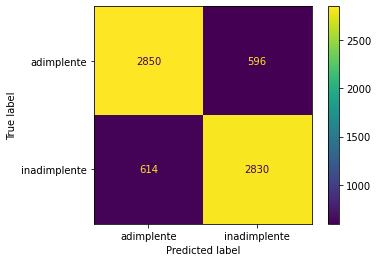

In [155]:
cm = confusion_matrix(y_test,
                      y_pred)

cm_display = ConfusionMatrixDisplay(cm,
                                    display_labels=['adimplente', 'inadimplente']).plot(values_format = '.0f')

## Script to make the call on the endpoint

In [156]:
import boto3

endpoint_name = 'bytebankSDKEndpoint'

runtime = \
    boto3.Session().client(
        service_name='sagemaker-runtime',
        region_name='us-east-1'
)

payload \
    = '140000,2,2,1,37,0,0,0,0,0,0,58081,51013,54343,27537,9751,12569,5000,5000,5000,3000,3000,5000'


response = \
    runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='text/csv',
        Body=payload
)

In [157]:
print(response)


{'ResponseMetadata': {'RequestId': '799d7a9e-408b-4b59-a427-e91cb056ffed', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '799d7a9e-408b-4b59-a427-e91cb056ffed', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Thu, 21 Jul 2022 18:57:59 GMT', 'content-type': 'text/csv; charset=utf-8', 'content-length': '3'}, 'RetryAttempts': 0}, 'ContentType': 'text/csv; charset=utf-8', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7fa8aa611910>}


In [158]:
predicao = int(float((response['Body'].read().decode('UTF-8'))))
print(f'Crédito será inadimplente?: {predicao}')

Crédito será inadimplente?: 0


## Removal of built artifacts

In [159]:
model_endpoint.endpoint_name

'bytebankSDKEndpoint'

In [160]:
session_sagemaker_sdk.delete_endpoint_config('bytebankSDKEndpoint')

In [161]:
session_sagemaker_sdk.delete_model('bytebankPythonSDK-2021-02-15-21-43-56-913')

In [162]:
session_sagemaker_sdk.delete_endpoint('bytebankSDKEndpoint')